# Godwin's Law on Reddit

Author: [@edridgedsouza](https://github.com/edridgedsouza/GODWIN)

Second Jupyter notebook for playing with the database while the other one is busy scraping.

**DISCLAIMER**: The selection of subreddits is clearly not random. By necessity, it includes
the most popular subreddits and subreddits that include the most-commented threads, as well
as some individually added political (or political-adjacent) subs. This alone tells you that
the sample space is not truly random; however, this is partly necessary as the only way to 
sample threads with high comment counts is often to take the most popular subs. However,
the manual inclusion of so many political subs likely influences the results and averages,
so another analysis is needed to see the rates only for explicitly non-political subs.


To account for the bias provided by adding in political subs, part of this analysis
will also attempt to calculate separate statistics for subs that aren't political or
political-adjacent. However, this is clearly very subjective as even nominally 
"apolitical" content can very much be political. Anyone who wishes to categorize the subs
differently can download the database and try their own custom visualization.

Terminology: a "failure event" in a thread is any reference to any of the "failure words" in
[Scraper.py](https://github.com/edridgedsouza/GODWIN/blob/master/godwin/Scraper.py#L42).
Alex Miller [(2013)](https://alex.miller.im/files/Godwins-Law-Statistical-Analysis-Alex-Miller.pdf) has
created a more comprehensive list of failure words, but for the purpose of this analysis, the current
set will suffice. Perhaps a future iteration will be re-run with the more complete
set of failure words for comparison.

This project is forked from @lukashalim and draws inspiration from his original [Reddit post](https://www.reddit.com/r/dataisbeautiful/comments/2s0e7i/visualizing_godwins_law_on_reddit_oc/);
the original analysis looked at the 5000 top posts, while this analysis looks within each of ~250 subreddits
for the top 100 posts for t = month, year, and all, as well as for the 100 most commented posts in the sub.

Error bars and shaded intervals represent 95% confidence intervals. For the kernel density plots, the shaded intervals represent the 25th to 75th percentile data.

___________________________________

### Text of Reddit post

**Title**: [OC] [MiC] Analyzing Godwin's Law on Reddit: as comment threads get larger, the chances of at least one reference to Nazi Germany go up. ([IMAGE LINK](https://i.imgur.com/oA7SLQX.png)) (POST LINK)

**[OC].** 

Here are some more visualizations from my analysis. Error bars and shaded intervals represent 95% confidence intervals. For the kernel density plots, the shaded intervals represent the 25th to 75th percentile data.

- [Animated version](https://gfycat.com/raggedantiquegrunion) (no confidence intervals)

- [Black and white version](https://i.imgur.com/NZW2S6w.png) of the survival curve

- [Percentage passing, binned](https://i.imgur.com/VXbQWZU.png) by number of comments in thread.

- For the posts that fail, [how long does it take to fail](https://i.imgur.com/y8rg90i.png)? (Note: this is only a partial figure, broken down by subreddit. For the full figure, check the [GitHub project page](https://github.com/edridgedsouza/GODWIN))

- Which subreddits have the highest [percentage of failing posts](https://i.imgur.com/M9JwMR0.png)?


I was inspired by the [previous post](https://www.reddit.com/r/dataisbeautiful/comments/2s0e7i/visualizing_godwins_law_on_reddit_oc/) by /u/Lukas_Halim that used survival analysis to model Godwin's Law on Reddit. I [forked](https://github.com/edridgedsouza/GODWIN) his original [repository](https://github.com/lukashalim/GODWIN) and extended his scraper; rather than simply taking the top 5000 posts, I used the PRAW and PushShift APIs to scrape ~250 subreddits (including /r/all and /r/popular) for:

- top 100 posts of the month

- top 100 posts of the year

- top 100 posts of all time

- top 100 most commented posts

For the purpose of this analysis, a "failure event" refers to when a thread contains a comment with one of the (aptly named) "[failure words](https://github.com/edridgedsouza/GODWIN/blob/master/godwin/Scraper.py#L42)" associated with Nazi Germany. As with /u/Lukas_Halim's original analysis, I defined my "time to event" as the number of comments in a thread before a failure event occurred; for threads without a failure event (i.e. "passing" threads), this was simply the total number of comments. In both cases, this attempts to quantify "survival time" using number of comments rather than actual time. To understand the "cumulative hazard", I found [this link](https://stats.stackexchange.com/a/60250) helpful; to overly simplify, think of it as the number of failure events you expect to experience after X amount of time.

For full code and more in-depth explanations of these figures, check out the [Jupyter notebook](https://github.com/edridgedsouza/GODWIN/blob/master/Visualization.ipynb) on my GitHub. I aim to release the full scraped database if possible, at which point people are free under the MIT license to fork my repo and analyze the data by themselves. This scraper produced over 80k comment threads with almost 72mil analyzed comments; if you plan to run the scraper yourself, make sure you have a few days to spare! The rate limiter adds up. I only did the top 100 posts in each time frame but someone else may have the time to gather even more.

**A DISCLAIMER**: This analysis is meant to be a quantitative look at online rhetoric and is in no way an endorsement of such rhetoric. Comments discussing WWII on /r/history or analyzing modern-day fascist movements on /r/PoliticalDiscussion are, of course, vastly different from a comment on /r/funny casually comparing moderators to the Nazi regime. The latter trivializes the atrocities of the Nazis, while the former examples are vital in ensuring we understand our history and choose not to repeat it. When looking at any of the plots in this analysis, please understand this context before drawing conclusions about any particular subreddits. I have tried to handle this contentious topic with the appropriate sensitivity and objectivity but am open to any suggestions on how I may improve in this regard.

In [1]:
from godwin import Database, Scraper
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from scipy import stats, interpolate
import warnings
warnings.filterwarnings('ignore')

db = Database('Godwin.db')
posts = db.get_data()

qry = '''
        SELECT 
            subreddit, 
            count(comment_id) AS n_failing,
            count(post_id) AS n_total,
            round(100.0*count(comment_id)/count(post_id), 2)
                AS percent_failing,
            round(avg(num_comments), 2) 
                AS avg_comments,
            round(avg(num_prev_comments), 2) 
                AS avg_failure_comments
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing DESC;
      '''
summary = ps.sqldf(qry, {'posts': posts})
summary['percent_failing'] = summary['percent_failing'].astype(str) + '%'

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'{summary.shape[0]} subs, {posts.shape[0]} total posts')
    display(summary)

254 subs, 81790 total posts


subreddit  n_failing  n_total percent_failing  avg_comments  \
0    u_RedditNintendoSwitch          1        1          100.0%     573931.00   
1                  politics        271      319          84.95%      14117.83   
2       ENLIGHTENEDCENTRISM        262      313          83.71%        672.24   
3            PoliticalHumor        243      302          80.46%       2340.69   
4     PoliticalCompassMemes        239      298           80.2%       1535.39   
5                 AskReddit        281      351          80.06%      22248.01   
6                 worldnews        287      360          79.72%       7128.12   
7                      news        251      323          77.71%       9578.04   
8         LeopardsAteMyFace        187      242          77.27%       1458.40   
9            PublicFreakout        225      297          75.76%       5646.36   
10         TopMindsOfReddit        245      325          75.38%        691.51   
11    AgainstHateSubreddits        229      305          75.08%        364.40   
12              Libertarian        239      320          74.69%       1525.16   
13               conspiracy        256      354          72.32%       1209.88   
14           SubredditDrama        204      284          71.83%       2042.52   
15                BreadTube        222      310          71.61%        338.38   
16          MurderedByWords        211      298          70.81%       2293.60   
17     insanepeoplefacebook        229      327          70.03%       1711.92   
18       AskTrumpSupporters        186      268           69.4%       1042.08   
19       WhitePeopleTwitter        204      294          69.39%       2333.39   
20                   europe        233      336          69.35%       2018.67   
21               neoliberal        241      349          69.05%       5294.16   
22             Conservative        194      285          68.07%       2164.15   
23            todayilearned        238      350           68.0%       3371.42   
24          COMPLETEANARCHY        225      332          67.77%        189.45   
25              nottheonion        213      318          66.98%       3030.31   
26         unpopularopinion        209      313          66.77%       3546.28   
27            Documentaries        216      325          66.46%       1655.24   
28      LateStageCapitalism        230      352          65.34%        725.64   
29         Bad_Cop_No_Donut        172      265          64.91%       1464.16   
30               Futurology        221      342          64.62%       2603.00   
31          ABoringDystopia        183      288          63.54%        992.23   
32                 facepalm        181      286          63.29%       1897.87   
33            JusticeServed        186      297          62.63%       4058.09   
34                   progun        207      333          62.16%        539.14   
35                   trashy        208      337          61.72%       2144.56   
36                     pics        221      360          61.39%       5166.34   
37               technology        209      343          60.93%       3036.29   
38               ukpolitics        227      373          60.86%       1304.50   
39                   movies        220      365          60.27%       6354.30   
40               RussiaLago        154      256          60.16%        197.11   
41             OutOfTheLoop        179      298          60.07%       1225.77   
42              Cringetopia        177      296           59.8%       1714.13   
43             communism101        163      275          59.27%         67.21   
44               philosophy        183      310          59.03%        721.22   
45                socialism        187      319          58.62%        332.75   
46              HistoryPorn        183      313          58.47%        500.95   
47                  atheism        203      350           58.0%       1462.46   
48           wallstreetbets        182      316  

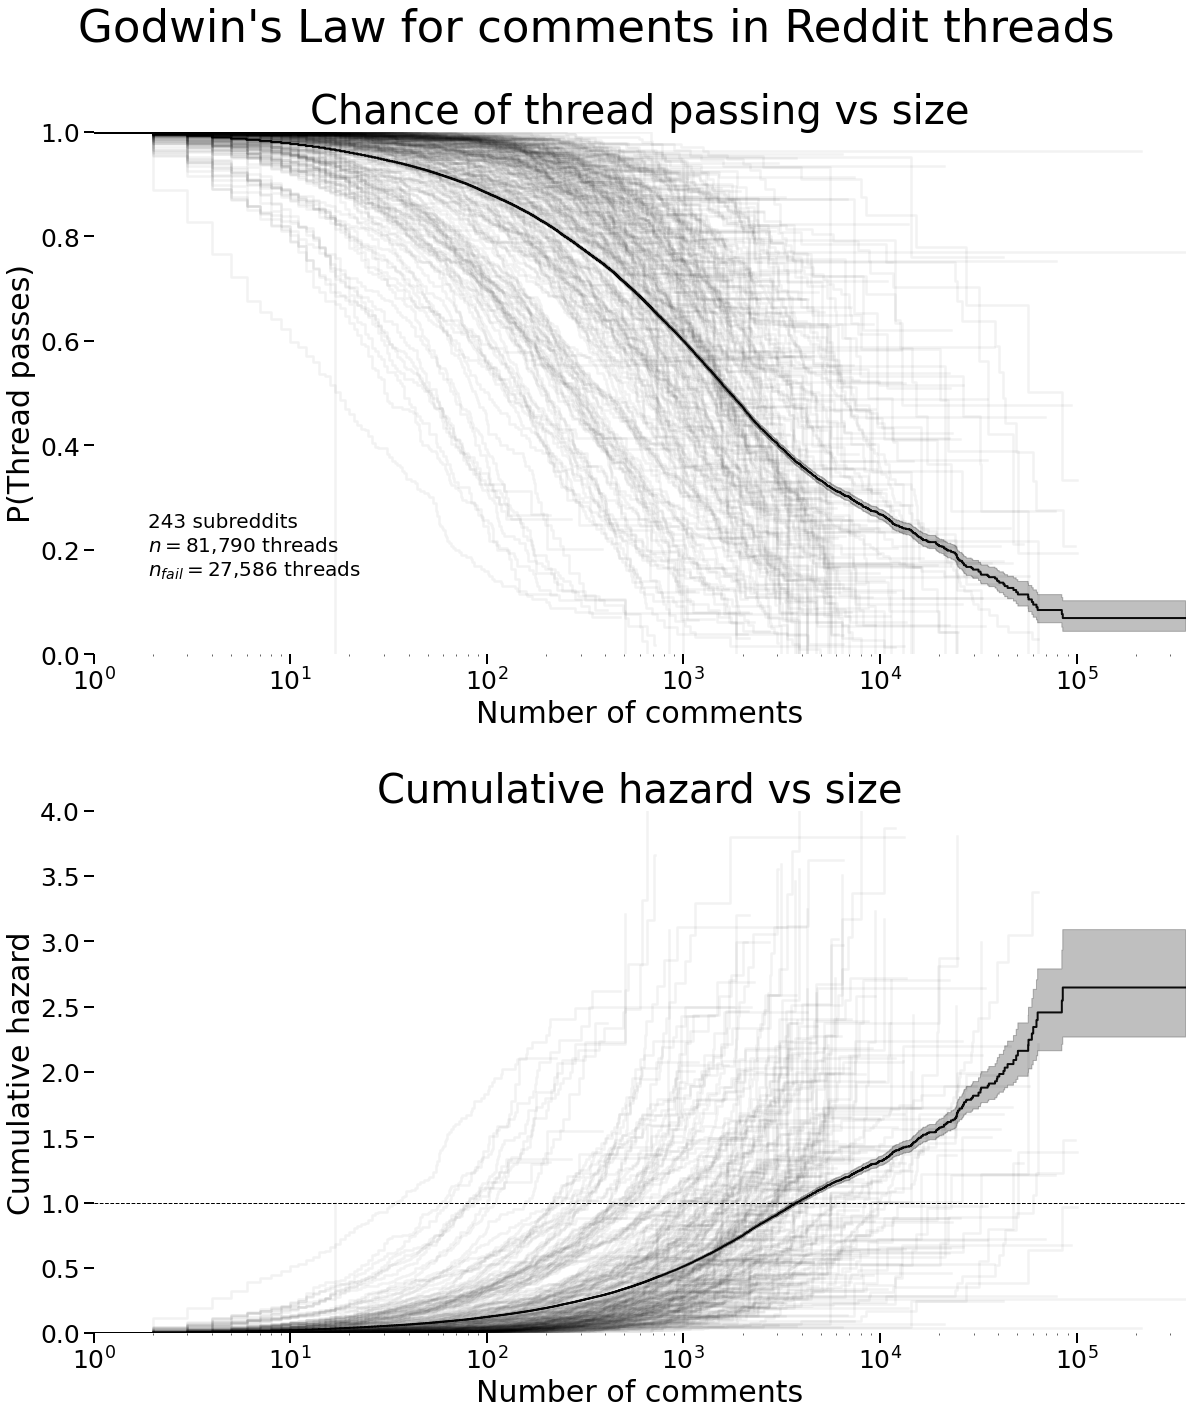

In [2]:
posts = db.get_data(fillna=True)

(fig, ax) = plt.subplots(2,1, figsize=(25 * 2/3, 15 * 4/3), facecolor=(1,1,1))

n = posts.shape[0]
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.str.lower().unique()  # Will plot noise from one-off posts on /r/all
subs = [i for i in subs 
        if i in Scraper.get_subs()]  # Will plot only the pre-defined list of major subs

for sub, subset in posts.groupby('subreddit'):
    kmf = KaplanMeierFitter()
    kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    kmf.plot(alpha=0.05, color='black', lw=2.5,
             ci_show=False, ax=ax[0])

    naf = NelsonAalenFitter()
    naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    naf.plot(alpha=0.05, color='black', lw=2.5,
             ci_show=False, ax=ax[1])
    
# Average model of all data
kmf = KaplanMeierFitter()
kmf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
kmf.plot(color='black', alpha=0.95, lw=2, ax=ax[0])

naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot(alpha=0.95, color='black', lw=2,
         ci_show=True, ax=ax[1])
####################################################################################

fig.suptitle(f"Godwin's Law for comments in Reddit threads\n", fontsize=45)
ax[0].set_title('Chance of thread passing vs size', fontsize=40)
ax[0].set_ylabel('P(Thread passes)', fontsize=30)
ax[1].set_title('Cumulative hazard vs size', fontsize=40)
ax[1].set_ylabel('Cumulative hazard', fontsize=30)

ax[1].set_ylim(0, 4)
ax[1].axhline(y=1.0, xmin=0, 
              xmax=posts.num_prev_comments.max(), 
              ls='--', lw=1, color='black')

for i in [0,1]:
    ax[i].set_xscale('log', base=10)
    ax[i].margins(x=0., y=0.)

    ax[i].get_legend().remove()
    ax[i].set_frame_on(False)

    ax[i].set_xlabel('Number of comments', fontsize=30)
    ax[i].tick_params(axis='x', labelsize=25)
    ax[i].tick_params(axis='y', labelsize=25)
    ax[i].tick_params(direction='out', length=10, width=2, colors='black')



samplesize = (f"{len(subs)} subreddits\n"
             f"$n=${n:,} threads\n"
             f"${'n_{fail}'}=${n_fail:,} threads")
ax[0].text(0.05, 0.15, samplesize, transform=ax[0].transAxes, fontsize=20)

fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


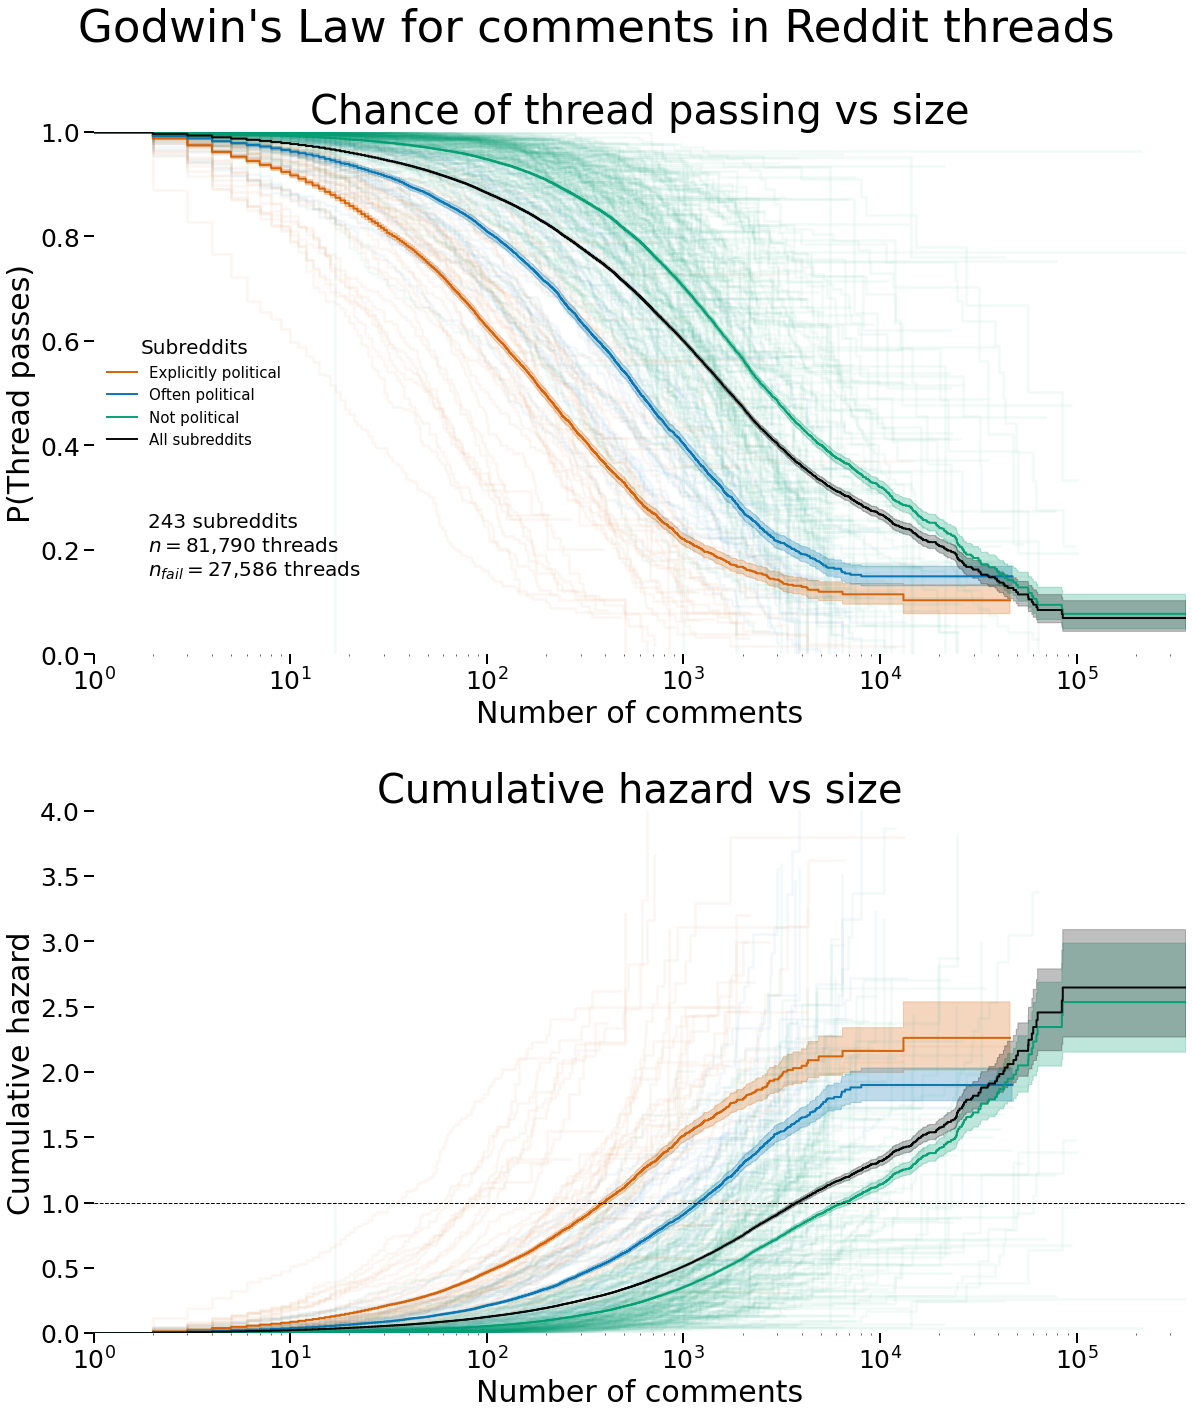

In [3]:
# Arguably the most subjective part of this analysis
# "Explicitly political" means any sub that is officially about discussion
# of politics or a particular political/social world view. 
# "Often political" means subs that are not explicitly about these things
# but which often feature political-related content or agendaposting

explicitly_political = ['aboringdystopia', 'againsthatesubreddits', 'anarchism',
                        'anarcho_capitalism', 'asktrumpsupporters', 'bad_cop_no_donut',
                        'breadtube', 'conservative', 'completeanarchy', 'enlightenedcentrism',
                        'feminism', 'firearms', 'genzedong', 'kotakuinaction', 'latestagecapitalism',
                        'leopardsatemyface', 'libertarian', 'mensrights', 'neutralpolitics',
                        'politicalcompassmemes', 'politicaldiscussion', 'politicalhumor',
                        'protectandserve', 'russialago', 'socialism_101', 'theredpill',
                        'topmindsofreddit', 'tumblrinaction', 'communism', 'communism101',
                        'conservatives', 'conspiracy', 'libertarianmeme', 'moderatepolitics',
                        'neoliberal', 'polandball', 'politics', 'progressive', 'progun', 'socialism',
                        'ukpolitics']

often_political = ['adviceanimals', 'askhistorians', 'blackpeopletwitter', 'coronavirus', 
                  'cringetopia', 'economics', 'europe', 'history', 'historyporn',
                  'justiceserved', 'murderedbywords', 'publicfreakout', 
                  'subredditdrama', 'whitepeopletwitter', 'badeconomics',
                  'barstoolsports', 'bestof', 'cringe', 'cringepics',
                  'facepalm', 'guns', 'history', 'iamatotalpieceofshit',
                  'insanepeoplefacebook', 'news','nottheonion', 'philosophy',
                  'technology', 'twoxchromosomes', 'worldnews']

def categorize(sub):
    sub = sub.lower()
    if sub in explicitly_political:
        return 'Explicitly political'
    elif sub in often_political:
        return 'Often political'
    else:
        return 'Not political'

posts = db.get_data(fillna=True)
posts['category'] = posts.subreddit.map(categorize)


##########################################################################################

(fig, ax) = plt.subplots(2,1, figsize=(25 * 2/3, 15 * 4/3), facecolor=(1,1,1))
pal = sns.color_palette('colorblind')

n = posts.shape[0]
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.str.lower().unique()  # Will plot noise from one-off posts on /r/all
subs = [i for i in subs 
        if i in Scraper.get_subs()]  # Will plot only the pre-defined list of major subs

for sub, subset in posts.groupby('subreddit'):
    category = categorize(sub)
    c = {'Explicitly political': pal[3], 
         'Often political': pal[0], 
         'Not political': pal[2]}.get(category)
    
    kmf = KaplanMeierFitter()
    kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    kmf.plot(alpha=0.05, color=c, lw=2.5,
             ci_show=False, ax=ax[0], label='_nolegend_')

    naf = NelsonAalenFitter()
    naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    naf.plot(alpha=0.05, color=c, lw=2.5,
             ci_show=False, ax=ax[1], label='_nolegend_')
    
# Average model of all data
def average_subset(subset, color, label):
    kmf = KaplanMeierFitter()
    kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    kmf.plot(color=color, alpha=0.95, lw=2, ax=ax[0], label=label)
    naf = NelsonAalenFitter()
    naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    naf.plot(alpha=0.95, color=color, lw=2,
             ci_show=True, ax=ax[1])
    

average_subset(posts[posts['category']=='Explicitly political'], 
               pal[3], 'Explicitly political')
average_subset(posts[posts['category']=='Often political'], 
               pal[0], 'Often political')
average_subset(posts[posts['category']=='Not political'], 
               pal[2], 'Not political')
average_subset(posts, 'black', 'All subreddits')

####################################################################################

fig.suptitle(f"Godwin's Law for comments in Reddit threads\n", fontsize=45)
ax[0].set_title('Chance of thread passing vs size', fontsize=40)
ax[0].set_ylabel('P(Thread passes)', fontsize=30)
ax[1].set_title('Cumulative hazard vs size', fontsize=40)
ax[1].set_ylabel('Cumulative hazard', fontsize=30)

ax[1].set_ylim(0, 4)
ax[1].axhline(y=1.0, xmin=0, 
              xmax=posts.num_prev_comments.max(), 
              ls='--', lw=1, color='black')

for i in [0,1]:
    ax[i].set_xscale('log', base=10)
    ax[i].margins(x=0., y=0.)

    ax[i].get_legend().remove()
    ax[i].set_frame_on(False)

    ax[i].set_xlabel('Number of comments', fontsize=30)
    ax[i].tick_params(axis='x', labelsize=25)
    ax[i].tick_params(axis='y', labelsize=25)
    ax[i].tick_params(direction='out', length=10, width=2, colors='black')

leg = ax[0].legend(facecolor='white', prop={'size': 15}, framealpha=0, loc='center left')
leg.set_title('Subreddits', prop = {'size':20})


samplesize = (f"{len(subs)} subreddits\n"
             f"$n=${n:,} threads\n"
             f"${'n_{fail}'}=${n_fail:,} threads")
ax[0].text(0.05, 0.15, samplesize, transform=ax[0].transAxes, fontsize=20)

fig.tight_layout()
fig.subplots_adjust(hspace=0.3)


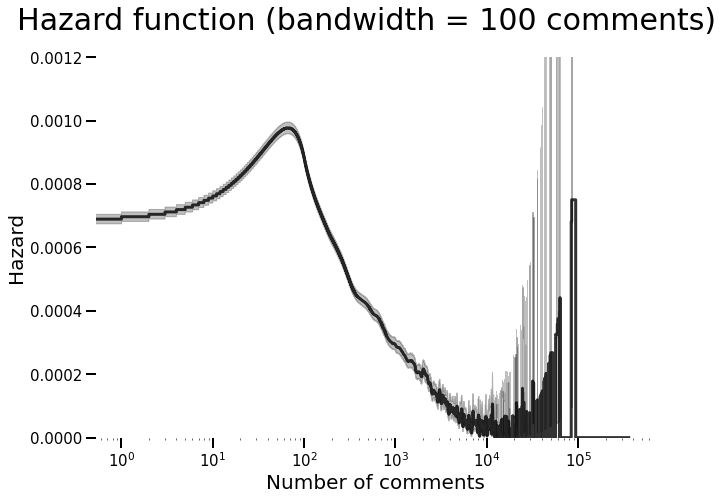

In [4]:
posts = db.get_data(fillna=True)

(fig, ax) = plt.subplots(1,1, figsize=(10,7), facecolor=(1,1,1))
naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot_hazard(color='black', alpha=0.8, ax=ax, lw=3, bandwidth=100)
ax.set_xscale('log', base=10)

fig.suptitle('Hazard function (bandwidth = 100 comments)', fontsize=30)
ax.set_xlabel('Number of comments', fontsize=20)
ax.set_ylabel('Hazard', fontsize=20)
ax.set_ylim(0, 0.0012)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.get_legend().remove()
plt.box(on=None)

# Good amount of noise for higher n_comments
# I wouldn't put too much stock in these. For basically any bandwidth n you use,
# the hazard raises until it reaches its peak where x = n. More than anything, this reflects the sparseness
# of threads with comment counts that fit within this bin size of n (also: the
# log scale will necessarily be shallow slope until n but take up a large-ish though sparse space on the plot after n)
# Then the variability gets high for larger x-values because data is more sparse than bandwidth

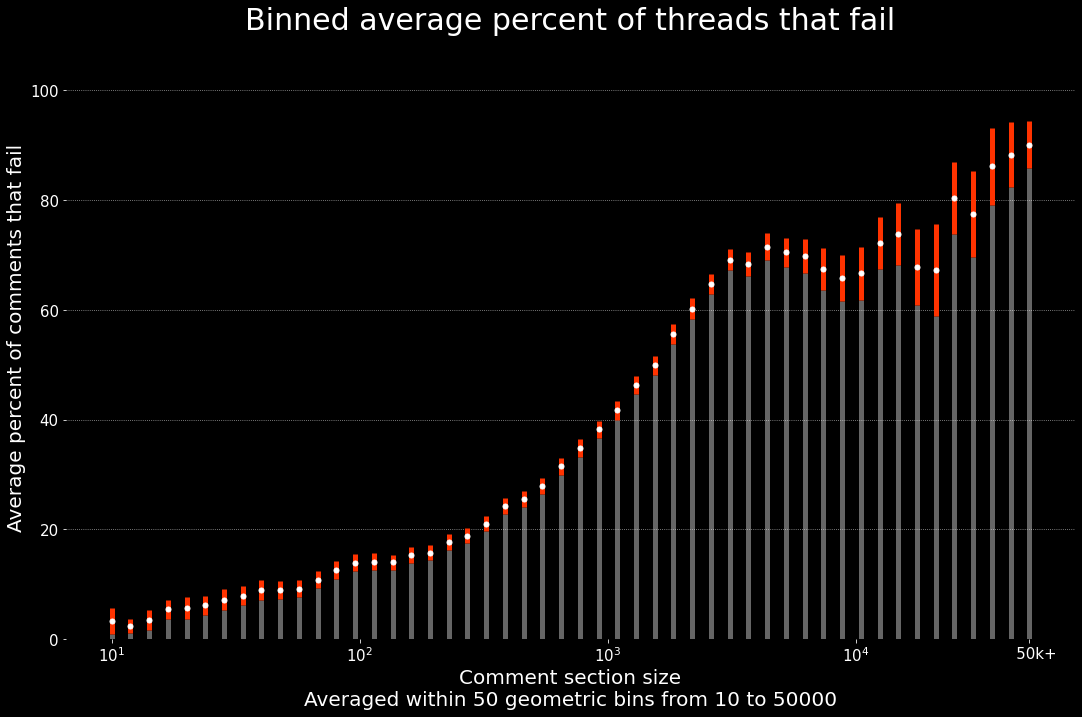

In [5]:
posts = db.get_data(fillna=True)

minimum = 10
maximum = 50000
num = 50
x = np.geomspace(minimum, maximum, num=num)

# There is definitely a smarter way to group results into uneven width bins
grps = [0] * len(x)
for i in range(len(x)):  # doesn't let you just iterate over x? Not sure why
    bin_min = x[i]
    if i < len(x) - 1:
        bin_max = x[i+1]
    else:
        bin_max = np.Inf
        
    subset = posts[(posts.num_comments > bin_min) & (posts.num_comments < bin_max)]
    grps[i] = list(subset.failure)

p = np.array([np.mean(i) for i in grps])
n = np.array([len(i) for i in grps])
ci = np.sqrt(p*(1-p)/n) * stats.norm.interval(0.95)[1] * 100  # That math minor sure paid off huh
p = p * 100

(fig, ax) = plt.subplots(1,1, figsize=(15, 10), facecolor=(0,0,0))
data = pd.DataFrame({'x':x, 'p': p, 'ci': ci})
data = data[~pd.isnull(data.p)]

lw = 5
ax.vlines(x=data.x, 
          ymin=0, ymax=data.p-data.ci, 
          color=(1,1,1, .4), lw=lw, zorder=5)
ax.vlines(x=data.x, 
          ymin=data.p-data.ci, 
          ymax=data.p+data.ci, 
          color=(1,0.2,0), lw=lw, zorder=6)
ax.plot(data.x, data.p, "o", c='white', markersize=lw, zorder=7)

ax.set_ylim(0, 110)
ax.set_xscale('log', base=10)

ax.set_title('Binned average percent of threads that fail', fontsize=30, color='white')
ax.set_xlabel(f'Comment section size\n'
              f'Averaged within {num} geometric bins from {minimum} to {maximum}', fontsize=20, color='white')
ax.set_ylabel(f'Average percent of comments that fail', fontsize=20, color='white')

fig.tight_layout()
ax.grid(which='major', axis='y', linestyle=':')
ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)
ax.set_xticks([10**1, 10**2, 10**3, 10**4, 50000])
ax.set_xticklabels(['$10^1$', '$10^2$', '$10^3$', '$10^4$', '   50k+'])
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
plt.box(on=None)

# Note: these represent only the average of the comments size WITHIN each of the bin boundaries
# NOT the same as the cumulative probability in the survival plot

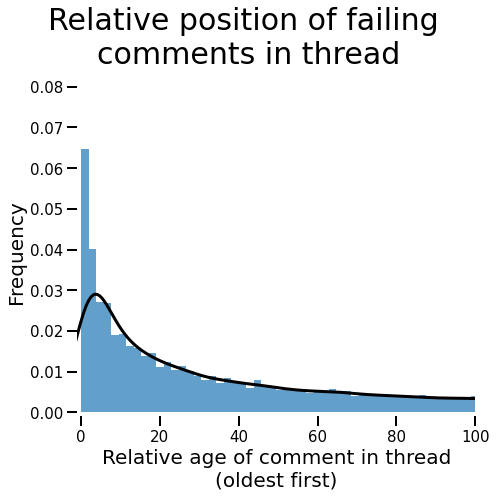

In [6]:
posts = db.get_data(fillna=True)

hits = posts[posts.failure == 1]

# Can technically be somewhat over 100 since the two different APIs 
# don't seem to be in exact accordance with each other
hits['percentile'] = (5*100*hits.num_prev_comments/hits.num_comments).round()/5

(fig, ax) = plt.subplots(1,1, figsize=(7,7), facecolor=(1,1,1))
hits['percentile'].plot.hist(density=True, bins=100, alpha=0.7, ax=ax)
hits['percentile'].plot.kde(legend=False, color='black', lw=3, ax=ax)

ax.set_xlabel('Relative age of comment in thread\n(oldest first)', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
fig.suptitle('Relative position of failing \ncomments in thread', fontsize=30)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.set_xlim(-1, 100)
ax.set_ylim(-0.001, 0.08)
fig.tight_layout()
plt.box(on=None)

# The bias towards the start is somewhat expected, as we only count the first failure event
# rather than all occurrences of failure words

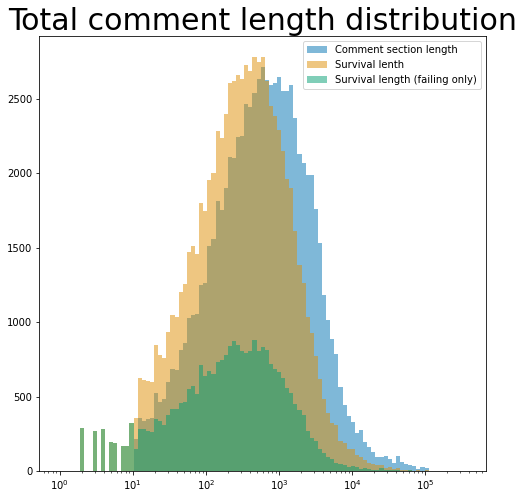

In [7]:
posts = db.get_data(fillna=True)

x = np.geomspace(1, posts.num_prev_comments.max(), num=100)
(fig, ax) = plt.subplots(1, 1, figsize=(8,8), facecolor=(1,1,1))
cm = sns.color_palette("colorblind")

ax.set_title('Total comment length distribution', fontsize=30)
params = {'stacked':False, 'fill':True, 'alpha': 0.5, 'edgecolor': 'none', 'bins': x}
d1 = ax.hist(posts.num_comments,  **params, 
             label='Comment section length', color=cm[0])
d2 = ax.hist(posts.num_prev_comments, **params, 
             label='Survival lenth', color=cm[1])
d3 = ax.hist(posts[posts.failure == 1].num_prev_comments, **params, 
             label='Survival length (failing only)', color=cm[2])

ax.legend(facecolor='white')
ax.set_xscale('log', base=10)

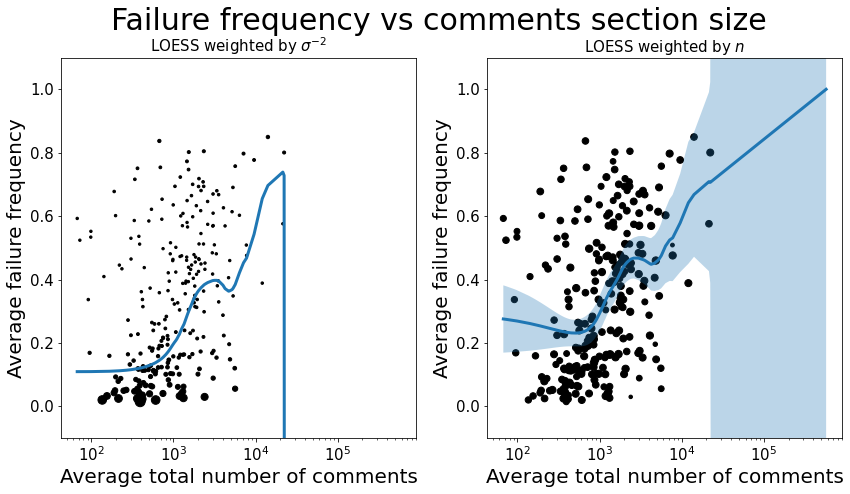

In [8]:
from skmisc.loess import loess

posts = db.get_data(fillna=False)

data = (posts.groupby(['subreddit'])
        .agg({'num_comments': [np.mean, np.var, 'count'], 
              'failure': [np.mean, np.var, 'count']}))
x, y = data[('num_comments', 'mean')], data[('failure', 'mean')]

# Weighting by variance causes a lot of zero weights and NaN conf intervals
w1 = 1 / (data[('failure', 'var')])
w1 = w1.replace([np.inf, -np.inf], np.nan).fillna(0)
w1 = w1 / w1.max()

# Weighting by sample size at least works
w2 = data[('failure', 'count')]
w2 = w2 / w2.max()


data2 = pd.DataFrame({'x': x, 'y': y, 'w1': w1, 'w2': w2}).sort_values('x')

(fig, ax) = plt.subplots(1,2, figsize=(14,7), facecolor=(1,1,1))
fig.suptitle('Failure frequency vs comments section size', fontsize=30)

for i in range(2):
    if i==0:
        w = data2.w1
        method = '$\sigma^{-2}$'
        sizes = ((w*100)**1)
    if i==1:
        w = data2.w2
        method = '$n$'
        sizes = ((w*40)**1.1)
    
    l = loess(data2.x, data2.y, surface='direct', weights=w)
    prd = l.predict(data2.x, stderror=True)
    ci = prd.confidence(alpha=0.05)
    
    ax[i].scatter(data2.x, data2.y, c='black', s=sizes)
    ax[i].plot(data2.x, prd.values, zorder=10, lw=3)
    ax[i].fill_between(data2.x, ci.lower, ci.upper, alpha=0.3)
                  
    ax[i].set_xlabel('Average total number of comments', fontsize=20)
    ax[i].set_ylabel('Average failure frequency', fontsize=20)
    ax[i].set_xscale('log', base=10)
    ax[i].set_ylim(-.1, 1.1)
    ax[i].set_title(f'LOESS weighted by {method}', fontsize=15)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)

# Each dot is a subreddit and therefore is averaged in both x and y directions.
# This is why it doesn't line up exactly with the binned matchstick plot, which
# is averaged in y but *binned* in x in a way that ignores subreddit.

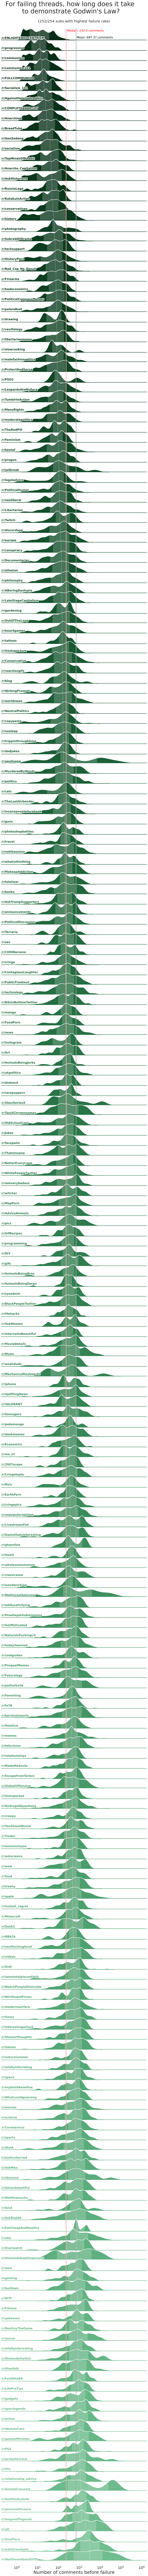

In [14]:
# Based on https://seaborn.pydata.org/examples/kde_ridgeplot.html

import matplotlib.patheffects as PathEffects

posts = db.get_data(fillna=False)
average = round(posts.num_prev_comments.mean(), 2)
median_val = round(posts.num_prev_comments.median(), 2)


subset = posts[(posts.failure == 1)]
fail_ct = subset.groupby('subreddit')['failure'].count()
fail_ct = fail_ct[fail_ct > 3]  # > 3 for full plot, >75 for reddit posting, > 130 for testing


subset = subset[subset.subreddit.isin(fail_ct.index)]
order = subset.groupby('subreddit')["num_prev_comments"].median().sort_values().index


sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(len(order), start=2.1, rot=0., gamma=0.9, hue=1, 
                            dark=0.1, light=0.6, reverse=True)
g = sns.FacetGrid(subset, row="subreddit", hue="subreddit", 
                  aspect=15, height=.8, palette=pal, sharey=False,
                 row_order = order, hue_order=order).set(xscale ='log')

# Draw the densities in a few steps
g.map(sns.kdeplot, "num_prev_comments",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "num_prev_comments", 
      clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Draw the mean and stdev https://stackoverflow.com/a/63309583/15014819
def draw_interval(x, color, label):
    ax = plt.gca()
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    middle = x.median()
    left, middle, right = np.percentile(x, [25, 50, 75])
    
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='white', ls=':', lw=1.5)
    ax.fill_between(xs, -0.1, ys, where=(left <= xs) & (xs <= right), 
                    interpolate=False, facecolor='white', alpha=0.2)
    
def draw_avg(x, color, label):
    ax = plt.gca()
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    avg = average 
    med = median_val
    maximum = ys.max()
    ax.vlines(avg, 0, maximum*1.05, 
              color='black', ls='-', 
              alpha=1, lw=.5, zorder=99, 
              antialiased=False)
    ax.vlines(avg, 0, maximum, 
              color='white', ls='-', 
              alpha=1, lw=2.5, zorder=10, 
              antialiased=False)
    ax.vlines(med, 0, maximum*1.05, 
              color='red', ls='-', 
              alpha=1, lw=.5, zorder=99, 
              antialiased=False)
    ax.vlines(med, 0, maximum, 
              color='white', ls='-', 
              alpha=1, lw=2.5, zorder=10, 
              antialiased=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    txt = ax.text(0, .2, f'/r/{label}', fontweight="bold", color=color,
            ha="left", va="bottom", transform=ax.transAxes, fontsize=16)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

g.map(label, "num_prev_comments")
g.map(draw_avg, "num_prev_comments")
g.map(draw_interval, "num_prev_comments")


# It was literally so hard to get these values automatically right
# that I had to just trial-end-error values that work for different
# plot sizes, and then use interpolation to get values that mostly work.
n_subplots = np.array([6, 35, 78, 125, 179, 252])
top_value = np.array([.6, .9, .95, .96, .965, .97])
linear = interpolate.interp1d(n_subplots, top_value, kind='slinear')
top_pred = linear(g.axes.shape[0])

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.333, top=top_pred) 
g.set_titles("")
g.fig.suptitle('For failing threads, how long does it take \n'
                      'to demonstrate Godwin\'s Law?', fontsize=35)
g.despine(bottom=True, left=True)


first_plot_max = g.axes[0,0].lines[0].get_ydata().max()

# Mean and median text
txt = g.axes[0,0].text(median_val*1.1, 
                 0.7*first_plot_max, 
                 f'Median: {median_val} comments', 
                 color='red',
            ha="left", va="bottom", fontsize=16, zorder=100)
txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
txt = g.axes[0,0].text(average*1.1, 
                 0.1*first_plot_max, 
                 f'Mean: {average} comments', 
                 color='black',
            ha="left", va="bottom", fontsize=16, zorder=100)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])



g.axes[0,0].set_title(f'({len(fail_ct)}/{len(posts.subreddit.unique())} '
                      'subs with highest failure rate)\n', 
                      fontsize=20)
g.axes[-1,0].set_xlabel('Number of comments before failure', fontsize=25)
g.axes[-1,0].tick_params(axis='x', labelsize=20)
g.axes[-1,0].set_xscale('log', basex=10)
g.set(yticks=[])

# KDE plotted, each row has a different y axis. Median dotted line, 25th-75th %ile shaded

It seems that /r/wallstreetbets invokes Godwin's Law consistently within threads, but doesn't tend to do so very quickly

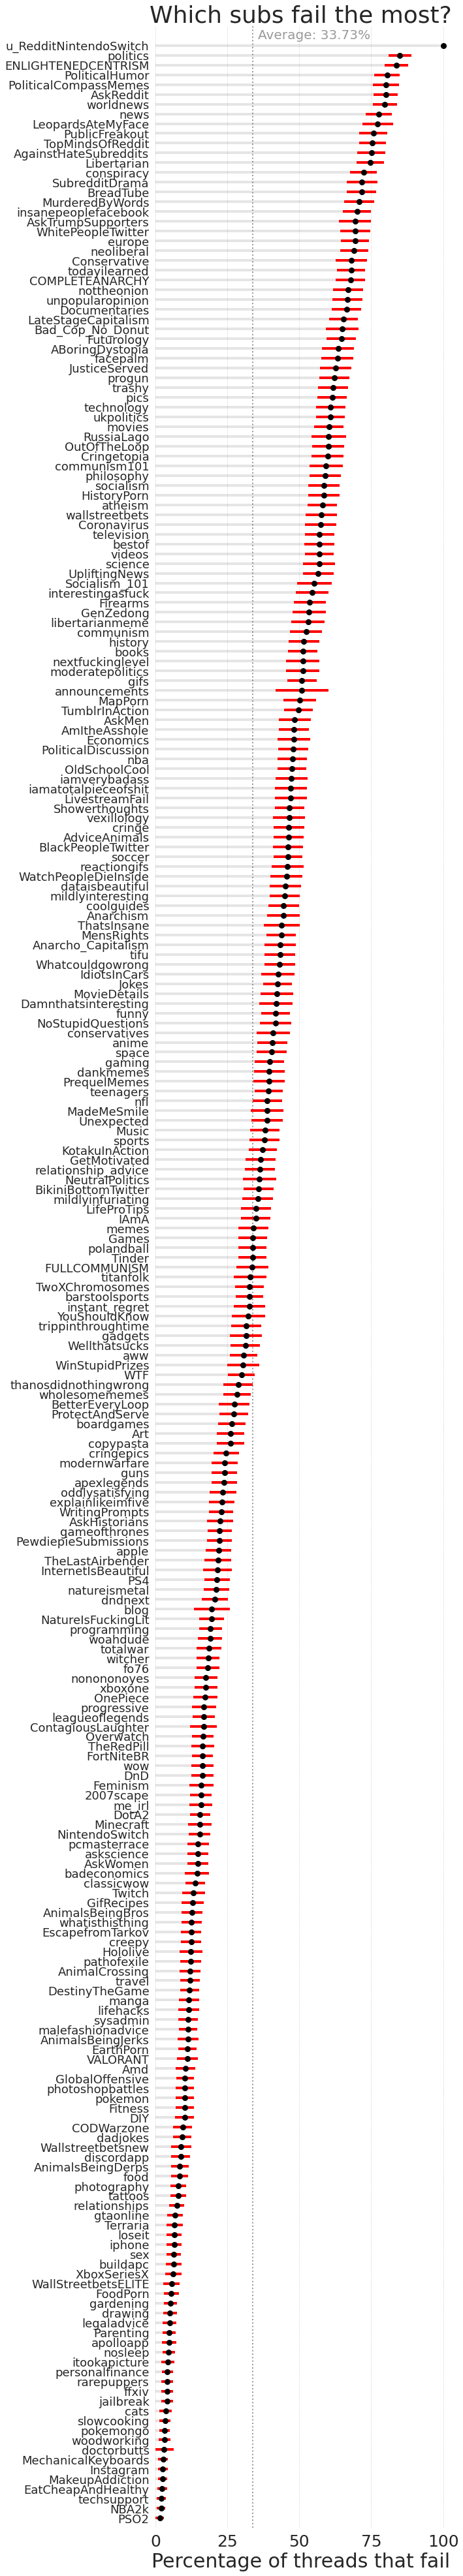

In [10]:
posts = db.get_data(fillna=False)


qry = '''
        SELECT 
            subreddit, 
            count(post_id) as n,
            1.0*count(comment_id)/count(post_id) AS p,
            round(100.0*count(comment_id)/count(post_id), 2)
                AS percent_failing
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing ASC;
      '''
summary = ps.sqldf(qry, {'posts': posts})
summary.ci = np.sqrt(summary.p * (1-summary.p) / summary.n) * stats.norm.interval(0.95)[1] * 100

y = summary.subreddit
y_n = np.arange(1,  len(y)+1)
x = summary.percent_failing

(fig, ax) = plt.subplots(1,1, figsize=(10, 55), facecolor=(1,1,1))

ax.hlines(y=y, 
          xmin=0, xmax=x-summary.ci, 
          color=(0,0,0,0.1), lw=4)
ax.hlines(y=y, 
          xmin=x-summary.ci, xmax=x+summary.ci, 
          color=(1,0,0), lw=4)
ax.plot(x, y, "o", c='black', markersize=8)

# These are really reversed
ax.set_xlim(0, 101)
ax.set_ylim(-1, len(y)+1)


ax.set_title('Which subs fail the most?', fontsize=36)
ax.set_xlabel('Percentage of threads that fail', fontsize=30)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=25)


avg = posts.count().comment_id / posts.count().post_id * 100
ax.axvline(x=avg, ymin=0, ymax=len(y), ls=':', lw=2, color='#999999', zorder=-1)
ax.text(avg+2, len(y)-0.3, 
        f'Average: {round(avg, 2)}%', 
        fontsize=20, color='#999999', zorder=10)

fig.tight_layout()
ax.grid(which='major', axis='x', linestyle=':')
plt.box(on=None)

# Animation

Recycling a lot of the previous code, but adding animation

In [421]:
import matplotlib.animation as animation
plt.rc('animation', html='html5')
plt.rcParams['animation.ffmpeg_path'] = '/users/edsouza/Install/bin/ffmpeg'

explicitly_political = ['aboringdystopia', 'againsthatesubreddits', 'anarchism',
                        'anarcho_capitalism', 'asktrumpsupporters', 'bad_cop_no_donut',
                        'breadtube', 'conservative', 'completeanarchy', 'enlightenedcentrism',
                        'feminism', 'firearms', 'genzedong', 'kotakuinaction', 'latestagecapitalism',
                        'leopardsatemyface', 'libertarian', 'mensrights', 'neutralpolitics',
                        'politicalcompassmemes', 'politicaldiscussion', 'politicalhumor',
                        'protectandserve', 'russialago', 'socialism_101', 'theredpill',
                        'topmindsofreddit', 'tumblrinaction', 'communism', 'communism101',
                        'conservatives', 'conspiracy', 'libertarianmeme', 'moderatepolitics',
                        'neoliberal', 'polandball', 'politics', 'progressive', 'progun', 'socialism',
                        'ukpolitics']

often_political = ['adviceanimals', 'askhistorians', 'blackpeopletwitter', 'coronavirus', 
                  'cringetopia', 'economics', 'europe', 'history', 'historyporn',
                  'justiceserved', 'murderedbywords', 'publicfreakout', 
                  'subredditdrama', 'whitepeopletwitter', 'badeconomics',
                  'barstoolsports', 'bestof', 'cringe', 'cringepics',
                  'facepalm', 'guns', 'history', 'iamatotalpieceofshit',
                  'insanepeoplefacebook', 'news','nottheonion', 'philosophy',
                  'technology', 'twoxchromosomes', 'worldnews']

def categorize(sub):
    sub = sub.lower()
    if sub in explicitly_political:
        return 'Explicitly political'
    elif sub in often_political:
        return 'Often political'
    else:
        return 'Not political'

posts = db.get_data(fillna=True)
posts['category'] = posts.subreddit.map(categorize)


##########################################################################################

(fig, ax) = plt.subplots(2,1, figsize=(25 * 2/3, 15 * 4/3), facecolor=(1,1,1))
pal = sns.color_palette('colorblind')

n = posts.shape[0]
max_x = posts.num_prev_comments.max()
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.str.lower().unique()  # Will plot noise from one-off posts on /r/all
subs = [i for i in subs 
        if i in Scraper.get_subs()]  # Will plot only the pre-defined list of major subs

for sub, subset in posts.groupby('subreddit'):
    category = categorize(sub)
    c = {'Explicitly political': pal[3], 
         'Often political': pal[0], 
         'Not political': pal[2]}.get(category)
    
    kmf = KaplanMeierFitter()
    kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    kmf.plot(alpha=0.05, color=c, lw=2.5,
             ci_show=False, ax=ax[0], label='_nolegend_')

    naf = NelsonAalenFitter()
    naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    naf.plot(alpha=0.05, color=c, lw=2.5,
             ci_show=False, ax=ax[1], label='_nolegend_')
    
# Average model of all data
def average_subset(subset, color, label):
    kmf = KaplanMeierFitter()
    kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    kmf.plot(color=color, alpha=0.95, lw=2, ax=ax[0], label=label)
    naf = NelsonAalenFitter()
    naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
    naf.plot(alpha=0.95, color=color, lw=2,
             ci_show=True, ax=ax[1])
    

average_subset(posts[posts['category']=='Explicitly political'], 
               pal[3], 'Explicitly political')
average_subset(posts[posts['category']=='Often political'], 
               pal[0], 'Often political')
average_subset(posts[posts['category']=='Not political'], 
               pal[2], 'Not political')
average_subset(posts, 'black', 'All subreddits')

####################################################################################

fig.suptitle(f"Godwin's Law for comments in Reddit threads\n", fontsize=45)
ax[0].set_title('Chance of thread passing vs size', fontsize=40, zorder=11)
ax[0].set_ylabel('P(Thread passes)', fontsize=30)
ax[1].set_title('Cumulative hazard vs size', fontsize=40, zorder=11)
ax[1].set_ylabel('Cumulative hazard', fontsize=30)

ymax = 4
ax[1].set_ylim(0, ymax)
ax[1].axhline(y=1.0, xmin=0, 
              xmax=posts.num_prev_comments.max(), 
              ls='--', lw=1, color='black', zorder=10)

for i in [0,1]:
    ax[i].set_xscale('log', base=10)
    ax[i].margins(x=0., y=0.)

    ax[i].get_legend().remove()
    ax[i].set_frame_on(False)

    ax[i].set_xlabel('Number of comments', fontsize=30)
    ax[i].tick_params(axis='x', labelsize=25)
    ax[i].tick_params(axis='y', labelsize=25)
    ax[i].tick_params(direction='out', length=10, width=2, colors='black')

leg = ax[0].legend(facecolor='white', prop={'size': 15}, framealpha=0, loc='center left')
leg.set_title('Subreddits', prop = {'size':20})


samplesize = (f"{len(subs)} subreddits\n"
             f"$n=${n:,} threads\n"
             f"${'n_{fail}'}=${n_fail:,} threads")
ax[0].text(0.05, 0.15, samplesize, transform=ax[0].transAxes, fontsize=20, zorder=10)

fig.tight_layout()
fig.subplots_adjust(hspace=0.3)



x = np.geomspace(1, posts.num_prev_comments.max(), 120)
ax[0].fill_between(x, 0, 1.05, 
                    color = 'white', 
                    alpha=1, animated=True, 
                    zorder=5);
ax[1].fill_between(x, 0, ymax+0.05, 
                    color = 'white', 
                    alpha=1, animated=True, 
                    zorder=5)

def update_data(i):
    x_new = x[i:]

    ax[0].collections.clear()
    ax[1].collections.clear()
    
    params = {'color':'white', 'alpha':1, 'animated':True, 'zorder':5}
    
    objs = []

    obj = ax[0].fill_between(x_new, 0, 1.05, **params)
    objs.append(obj)
    obj = ax[1].fill_between(x_new, 0, ymax+0.05, **params)
    objs.append(obj)
    
    return objs
    
anim = animation.FuncAnimation(fig, update_data, len(x)+100, interval=100, blit=True)
anim.save('survival.mp4', writer='ffmpeg')
plt.close()

# https://gfycat.com/raggedantiquegrunion